# Simulations with RNN with odeint

In [1]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Set the device to GPU
    device = torch.device("cuda")
    # This will make sure that tensors and models created will be moved to GPU
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np

# Old simulator without loops...
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params #only 3 ks are parameters to infer
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Initial conditions
true_params = torch.tensor([
    246.96291990024542, 246.96291990024542, 246.96291990024542])
num_timesteps = 100
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(params):
    y = odeint(model, y0, t, args=(params,))
    traj = torch.tensor(y, dtype=torch.float32).flatten()
    return traj.view(100,6)

true_data = simulator(true_params)
    
num_dim = 3
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))

In [10]:
true_data.shape

torch.Size([100, 6])

In [11]:
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)
batch_size = 3


In [12]:
fourdim = simulator_wrapper(prior.sample((batch_size,)))
fourdim.shape

torch.Size([3, 100, 6])

In [13]:
### IMPORT PACKAGES AND ALSO REWRITE FUNCTIONS ###

import torch
import multiprocessing
import os

def get_gpu_count():
    return torch.cuda.device_count()

def get_cpu_count():
    return multiprocessing.cpu_count()

if __name__ == "__main__":
    num_gpus = get_gpu_count()
    num_cpus = get_cpu_count()
    print("Number of GPUs (torch.cuda.device_count()):", num_gpus)
    print("Number of CPUs (multiprocessing.cpu_count()):", num_cpus)

print("Number of CPUs (os.cpu_count()):", os.cpu_count())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np

import joblib
import math
from math import ceil
import random
import contextlib
import torch
import sys
from numpy import fft, ndarray
from scipy.stats import norm
import os
import seaborn as sns
from pyro.infer.mcmc.api import MCMC
from warnings import warn
from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union, Dict
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm, trange
from pyro.infer.mcmc import HMC, NUTS
from sbi.inference import prepare_for_sbi, SNLE
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.types import Shape, TorchTransform
from sbi.utils.get_nn_models import (likelihood_nn,)
from sbi.samplers.mcmc import SliceSamplerVectorized
from sbi.samplers.mcmc.slice_numpy import MCMCSampler
from sbi.utils import tensor2numpy

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(10_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)
    
    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress
    
    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

class SliceSampler(MCMCSampler):
    def __init__(self, x, lp_f, max_width=float("inf"), init_width: Union[float, np.ndarray] = 0.05, thin=None, tuning: int = 50, verbose: bool = False,):
        MCMCSampler.__init__(self, x, lp_f, thin, verbose=verbose)
        self.max_width = max_width
        self.init_width = init_width
        self.width = None
        self.tuning = tuning
        
    def _tune_bracket_width(self, rng):
        order = list(range(self.n_dims))
        x = self.x.copy()

        self.width = np.full(self.n_dims, self.init_width)

        tbar = trange(self.tuning, miniters=2, disable=not self.verbose)
        tbar.set_description("Tuning bracket width...")
        for n in tbar:
            # for n in range(int(self.tuning)):
            rng.shuffle(order)
            for i in range(self.n_dims):
                x[i], wi = self._sample_from_conditional(i, x[i], rng)
                self.width[i] += (wi - self.width[i]) / (n + 1)

    def _sample_from_conditional(self, i: int, cxi, rng):
        assert self.width is not None, "Chain not initialized."

        # conditional log prob
        Li = lambda t: self.lp_f(np.concatenate([self.x[:i], [t], self.x[i + 1 :]]))
        wi = self.width[i]

        # sample a slice uniformly
        logu = Li(cxi) + np.log(1.0 - rng.rand())

        # position the bracket randomly around the current sample
        lx = cxi - wi * rng.rand()
        ux = lx + wi
        
        # find lower bracket end
        while Li(lx) >= logu and cxi - lx < self.max_width:
            lx -= wi

        # find upper bracket end
        while Li(ux) >= logu and ux - cxi < self.max_width:
            ux += wi

        # sample uniformly from bracket
        xi = (ux - lx) * rng.rand() + lx

        # if outside slice, reject sample and shrink bracket
        while Li(xi) < logu:
            if xi < cxi:
                lx = xi
            else:
                ux = xi
            xi = (ux - lx) * rng.rand() + lx
       
        return xi, ux - lx
      
def run_fun(SliceSamplerSerial, num_samples, inits, seed, log_prob_fn: Callable, thin: Optional[int] = None, tuning: int = 50, verbose: bool = True, init_width: Union[float, np.ndarray] = 0.01,
            max_width: float = float("inf"), num_workers: int = 1, rng=np.random, show_info: bool = False, logger=sys.stdout) -> np.ndarray:
    np.random.seed(seed)
    posterior_sampler = SliceSampler(inits, lp_f=log_prob_fn, max_width=max_width, init_width=init_width, thin=thin, tuning=tuning, verbose=num_workers == 1 and verbose,)
    
    assert num_samples >= 0, "number of samples can't be negative"

    order = list(range(posterior_sampler.n_dims))
    L_trace = []
    samples = np.empty([int(num_samples), int(posterior_sampler.n_dims)])
    logger = open(os.devnull, "w") if logger is None else logger

    if posterior_sampler.width is None:
        # logger.write('tuning bracket width...\n')
        posterior_sampler._tune_bracket_width(rng)

    tbar = trange(int(num_samples), miniters=10, disable=not posterior_sampler.verbose)
    tbar.set_description("Generating samples")
    for n in tbar:
        # for n in range(int(n_samples)):
        for _ in range(posterior_sampler.thin):
            rng.shuffle(order)

            for i in order:
                posterior_sampler.x[i], _ = posterior_sampler._sample_from_conditional(i, posterior_sampler.x[i], rng)

        samples[n] = posterior_sampler.x.copy()

        posterior_sampler.L = posterior_sampler.lp_f(posterior_sampler.x)
        # logger.write('sample = {0}, log prob = {1:.2}\n'.format(n+1, self.L))

        if show_info:
            L_trace.append(posterior_sampler.L)

    # show trace plot
    if show_info:
        fig, ax = plt.subplots(1, 1)
        ax.plot(L_trace)
        ax.set_ylabel("log probability")
        ax.set_xlabel("samples")
        plt.show(block=False)

    return samples

def run(SliceSamplerSerial, log_prob_fn: Callable, num_samples: int, init_params: np.ndarray, num_chains: int = 1, thin: Optional[int] = None, verbose: bool = True, num_workers: int = 1,) -> np.ndarray:
    num_chains , dim_samples = init_params.shape
    # Generate seeds for workers from current random state.
    seeds = torch.randint(high=1_000_000, size=(num_chains,))
    for seed in seeds:
        seed_all_backends(seed)
    with tqdm_joblib(tqdm(range(num_chains), disable=not verbose, desc=f"""Running {num_chains} MCMC chains with {num_workers} worker{"s" if num_workers>1 else ""}.""", total=num_chains,)):
        all_samples = Parallel(n_jobs=num_workers)(delayed(run_fun)(SliceSamplerSerial, num_samples, initial_params_batch, seed, log_prob_fn)for initial_params_batch, seed in zip(init_params, seeds))
    samples = np.stack(all_samples).astype(np.float32)
    samples = samples.reshape(num_chains, -1, dim_samples)  # chains, samples, dim
    samples = samples[:, :: thin, :]  # thin chains

    # save samples
    return samples

class SliceSamplerSerial:
    def __init__(self, log_prob_fn: Callable, init_params: np.ndarray, num_chains: int = 1, thin: Optional[int] = None, tuning: int = 50, verbose: bool = True, init_width: Union[float, np.ndarray] = 0.01, max_width: float = float("inf"), num_workers: int = 1,):
        self._log_prob_fn = log_prob_fn
        self.x = init_params
        self.num_chains = num_chains
        self.thin = thin
        self.tuning = tuning
        self.verbose = verbose
        self.init_width = init_width
        self.max_width = max_width
        self.n_dims = self.x.size
        self.num_workers = num_workers
        self._samples = None

    def get_samples(self, num_samples: Optional[int] = None, group_by_chain: bool = True) -> np.ndarray:
        if self._samples is None:
            raise ValueError("No samples found from MCMC run.")
        # if not grouped by chain, flatten samples into (all_samples, dim_params)
        if not group_by_chain:
            samples = self._samples.reshape(-1, self._samples.shape[2])
        else:
            samples = self._samples

        # if not specified return all samples
        if num_samples is None:
            return samples
        # otherwise return last num_samples (for each chain when grouped).
        elif group_by_chain:
            return samples[:, -num_samples:, :]
        else:
            return samples[-num_samples:, :]

##############################################################################################################################
        
def _maybe_use_dict_entry(default: Any, key: str, dict_to_check: Dict) -> Any:
    attribute = default if key not in dict_to_check.keys() else dict_to_check[key]
    return attribute

def _get_initial_params(proposal, init_strategy: str, num_chains: int, num_workers: int, show_progress_bars: bool, **kwargs,) -> Tensor: 
    # Build init function
    init_fn = proposal._build_mcmc_init_fn(proposal.proposal, proposal.potential_fn, transform=proposal.theta_transform, init_strategy=init_strategy, **kwargs,)

    # Parallelize inits for resampling only.
    if num_workers > 1 and (init_strategy == "resample" or init_strategy == "sir"):
        def seeded_init_fn(seed):
            torch.manual_seed(seed)
            return init_fn()

        seeds = torch.randint(high=10_000_000, size=(num_chains,))

        # Generate initial params parallelized over num_workers.
        with tqdm_joblib(tqdm(range(num_chains), disable=not show_progress_bars, desc=f"""Generating {num_chains} MCMC inits with {num_workers} workers.""", total=num_chains,)):
            initial_params = torch.cat(Parallel(n_jobs=num_workers)(delayed(seeded_init_fn)(seed) for seed in seeds))
    else:
        initial_params = torch.cat([init_fn() for _ in range(num_chains)])
    return initial_params
    
def _slice_np_mcmc(proposal, num_samples: int, potential_function: Callable, initial_params: Tensor, thin: int, warmup_steps: int, vectorized: bool = False, num_workers: int = 1, init_width: Union[float, ndarray] = 0.01, show_progress_bars: bool = True,) -> Tensor:
    num_chains, dim_samples = initial_params.shape
        
    if not vectorized:
        SliceSamplerMultiChain = SliceSamplerSerial
    else:
        SliceSamplerMultiChain = SliceSamplerVectorized

    posterior_sampler = SliceSamplerMultiChain(init_params=tensor2numpy(initial_params), log_prob_fn=potential_function, num_chains=num_chains, thin=thin, verbose=show_progress_bars, num_workers=num_workers, init_width=init_width,)
    warmup_ = warmup_steps * thin
    num_samples_ = ceil((num_samples * thin) / num_chains)
    # Run mcmc including warmup
    samples = run(posterior_sampler, log_prob_fn=potential_function, num_samples = (warmup_ + num_samples_), init_params = tensor2numpy(initial_params))
    samples = samples[:, warmup_steps:, :]  # discard warmup steps
    samples = torch.from_numpy(samples)  # chains x samples x dim

    # Save posterior sampler.
    proposal._posterior_sampler = posterior_sampler

    # Save sample as potential next init (if init_strategy == 'latest_sample').
    proposal._mcmc_init_params = samples[:, -1, :].reshape(num_chains, dim_samples)

    # Collect samples from all chains.
    samples = samples.reshape(-1, dim_samples)[:num_samples, :]
    assert samples.shape[0] == num_samples
    return samples.type(torch.float32).to(proposal._device)

def sample_my_fun(proposal, sample_shape: Shape = torch.Size(), x: Optional[Tensor] = None, method: Optional[str] = None, thin: Optional[int] = None, warmup_steps: Optional[int] = None, num_chains: Optional[int] = None, init_strategy: Optional[str] = None, init_strategy_parameters: Optional[Dict[str, Any]] = None,
                   init_strategy_num_candidates: Optional[int] = None, mcmc_parameters: Dict = {}, mcmc_method: Optional[str] = None, sample_with: Optional[str] = None, num_workers: Optional[int] = None, show_progress_bars: bool = True,) -> Tensor:
    
    proposal.potential_fn.set_x(proposal._x_else_default_x(x))

    # Replace arguments that were not passed with their default.
    method = proposal.method if method is None else method
    thin = proposal.thin if thin is None else thin
    warmup_steps = proposal.warmup_steps if warmup_steps is None else warmup_steps
    num_chains = proposal.num_chains if num_chains is None else num_chains
    init_strategy = proposal.init_strategy if init_strategy is None else init_strategy
    num_workers = proposal.num_workers if num_workers is None else num_workers
    init_strategy_parameters = (proposal.init_strategy_parameters if init_strategy_parameters is None else init_strategy_parameters)

    if init_strategy_num_candidates is not None:
        warn("""Passing `init_strategy_num_candidates` is deprecated as of sbi v0.19.0. Instead, use e.g.,`init_strategy_parameters={"num_candidate_samples": 1000}`""")
        proposal.init_strategy_parameters["num_candidate_samples"] = (init_strategy_num_candidates)
    if sample_with is not None:
        raise ValueError(f"You set `sample_with={sample_with}`. As of sbi v0.18.0, setting `sample_with` is no longer supported. You have to rerun `.build_posterior(sample_with={sample_with}).`")
    if mcmc_method is not None:
        warn("You passed `mcmc_method` to `.sample()`. As of sbi v0.18.0, this is deprecated and will be removed in a future release. Use `method` instead of `mcmc_method`.")
        method = mcmc_method
    if mcmc_parameters:
        warn("You passed `mcmc_parameters` to `.sample()`. As of sbi v0.18.0, this is deprecated and will be removed in a future release. Instead, pass the variable to `.sample()` directly, e.g. `posterior.sample((1,), num_chains=5)`.")
    # The following lines are only for backwards compatibility with sbi v0.17.2 or older.
    m_p = mcmc_parameters  # define to shorten the variable name
    method = _maybe_use_dict_entry(method, "mcmc_method", m_p)
    thin = _maybe_use_dict_entry(thin, "thin", m_p)
    warmup_steps = _maybe_use_dict_entry(warmup_steps, "warmup_steps", m_p)
    num_chains = _maybe_use_dict_entry(num_chains, "num_chains", m_p)
    init_strategy = _maybe_use_dict_entry(init_strategy, "init_strategy", m_p)
    proposal.potential_ = proposal._prepare_potential(method)  # type: ignore

    initial_params = _get_initial_params(proposal, init_strategy, num_chains, num_workers, show_progress_bars, **init_strategy_parameters,)
    num_samples = torch.Size(sample_shape).numel()

    track_gradients = method in ("hmc", "nuts")
    with torch.set_grad_enabled(track_gradients):
        if method in ("slice_np", "slice_np_vectorized"):
            transformed_samples = _slice_np_mcmc(proposal, num_samples=num_samples, potential_function=proposal.potential_, initial_params=initial_params, thin=thin, warmup_steps=warmup_steps, vectorized=(method == "slice_np_vectorized"), num_workers=num_workers, show_progress_bars=show_progress_bars,)
        elif method in ("hmc", "nuts", "slice"):
            transformed_samples = _pyro_mcmc(proposal, num_samples=num_samples, potential_function=proposal.potential_, initial_params=initial_params, mcmc_method=method, thin=thin, warmup_steps=warmup_steps, num_chains=num_chains, show_progress_bars=show_progress_bars,)
        else:
            raise NameError

    samples = proposal.theta_transform.inv(transformed_samples)

    return samples.reshape((*sample_shape, -1))  # type: ignore

#######################################################################################################################################

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1 , seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:
    num_sims, *_ = theta.shape
    seed_all_backends(seed)
    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)
        
        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))
            with tqdm_joblib(tqdm(batches, disable=not show_progress_bars, total = len(batches), desc=f"Running {num_sims} simulations in {len(batches)} batches ({num_workers} cores)",)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed) for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )
            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)
        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)
    return x

def simulate_for_sbi(round_idx: int, simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1, simulation_batch_size: int = 1, seed: Optional[int] = None, show_progress_bar: bool = True)-> Tuple[Tensor, Tensor]:
    if round_idx == 0:
        theta = proposal.sample((num_simulations,))
    else:
        theta = sample_my_fun(proposal, (num_simulations,), num_workers = num_workers, num_chains = 4) # because only in first round proposal is boxuniform, then it is mcmcposterior object
    
    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size, num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar)
    
    return theta, x


Number of GPUs (torch.cuda.device_count()): 0
Number of CPUs (multiprocessing.cpu_count()): 8
Number of CPUs (os.cpu_count()): 8


## RNN

In [24]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True) #batch_size of 100
        self.linear = nn.Linear(hidden_size, output_size)

                                                       #The middle value needs to be the length, in this case 1000, or input.size(0) (try with true_data)
                                                        #1 is the number of layers
                                                        #Actually prepare for sbi adds a batch_size, so x.shape is (1, 1000, 6)
    def forward(self, x):
        h = torch.zeros(1, x.size(0), self.hidden_size)
        gru_out, hn = self.gru(
            x, h)
        output = self.linear(gru_out[:,-1, :])
        return output

# Example usage
input_size = 6 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [28]:
gru = nn.GRU(6, 100, batch_first=True)
h = torch.zeros(1, 3, 100)
gru_out, hn = gru(true_data, h)
linear = nn.Linear(hidden_size, output_size)
out = linear(gru_out[:,-1, :])
out.shape

RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor

In [18]:
##### paralellise #####

#Parallelise it
# PART 1: Edited code from original sbi repos. Functions edited: simulate_for_sbi, and all the functions it contains.
#Main changes: defined simulator_seeded globally rather than within simulate_in_batches function, and re-imported torch within simulator_seeded 
#NO changes need to be made in this file

# PART 2: Essentially the unparallelised code with 2 extra arguments in the simulate_for_sbi line

##################################### PART 1 #########################################
import joblib
import contextlib
import random
import torch
import numpy as np

from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sbi
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

from sbi.inference import SNLE, prepare_for_sbi
# No longer importing simulate_for_sbi from the package, we use the one defined above
from sbi import utils as utils
from sbi import analysis as analysis

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(1_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1,
                        seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:

    num_sims, *_ = theta.shape
    seed_all_backends(seed)

    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)

        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))

            with tqdm_joblib(
                tqdm(batches, disable=not show_progress_bars,
                     desc=f"Running {num_sims} simulations in {len(batches)} batches.", total=len(batches),)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed)
                    for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )

            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)

        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)

    return x


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

def simulate_for_sbi(simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1,
                     simulation_batch_size: int = 1, seed: Optional[int] = None,
                     show_progress_bar: bool = True, ) -> Tuple[Tensor, Tensor]:

    theta = proposal.sample((num_simulations,))

    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size,
                            num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar,)

    return theta, x

######################################################################################################

# To parallelise, set number of CPUs to be used. Note: parallelise anything that has num_rounds>2 and/or num_simulations>50
# to see total available CPUs: print(os.cpu_count())

CPUs_to_use = 8

total_CPUs = os.cpu_count()
num_workers = CPUs_to_use - total_CPUs -1
# num_workers = -1 uses all cpus
# num_workers = -2 uses all cpus but one etc https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
if CPUs_to_use > total_CPUs:
    raise ValueError(f"Cannot use more CPUs than are available. Available CPUs: {total_CPUs}")


In [ ]:
######## snpec gpu ######

# This file is part of sbi, a toolkit for simulation-based inference. sbi is licensed
# under the Affero General Public License v3, see <https://www.gnu.org/licenses/>.


from typing import Callable, Dict, Optional, Union

import torch
from pyknos.mdn.mdn import MultivariateGaussianMDN as mdn
from pyknos.nflows.transforms import CompositeTransform
from torch import Tensor, eye, nn, ones
from torch.distributions import Distribution, MultivariateNormal, Uniform

from sbi import utils as utils
from sbi.inference.posteriors.direct_posterior import DirectPosterior
from sbi.inference.snpe.snpe_base import PosteriorEstimator
from sbi.types import TensorboardSummaryWriter
from sbi.utils import (
    batched_mixture_mv,
    batched_mixture_vmv,
    check_dist_class,
    clamp_and_warn,
    del_entries,
    repeat_rows,
)


class SNPE_C(PosteriorEstimator):
    def __init__(
        self,
        prior: Optional[Distribution] = None,
        density_estimator: Union[str, Callable] = "maf",
        device: str = "gpu",
        logging_level: Union[int, str] = "WARNING",
        summary_writer: Optional[TensorboardSummaryWriter] = None,
        show_progress_bars: bool = True,
    ):
        r"""SNPE-C / APT [1].

        [1] _Automatic Posterior Transformation for Likelihood-free Inference_,
            Greenberg et al., ICML 2019, https://arxiv.org/abs/1905.07488.

        This class implements two loss variants of SNPE-C: the non-atomic and the atomic
        version. The atomic loss of SNPE-C can be used for any density estimator,
        i.e. also for normalizing flows. However, it suffers from leakage issues. On
        the other hand, the non-atomic loss can only be used only if the proposal
        distribution is a mixture of Gaussians, the density estimator is a mixture of
        Gaussians, and the prior is either Gaussian or Uniform. It does not suffer from
        leakage issues. At the beginning of each round, we print whether the non-atomic
        or the atomic version is used.

        In this codebase, we will automatically switch to the non-atomic loss if the
        following criteria are fulfilled:<br/>
        - proposal is a `DirectPosterior` with density_estimator `mdn`, as built
            with `utils.sbi.posterior_nn()`.<br/>
        - the density estimator is a `mdn`, as built with
            `utils.sbi.posterior_nn()`.<br/>
        - `isinstance(prior, MultivariateNormal)` (from `torch.distributions`) or
            `isinstance(prior, sbi.utils.BoxUniform)`

        Note that custom implementations of any of these densities (or estimators) will
        not trigger the non-atomic loss, and the algorithm will fall back onto using
        the atomic loss.

        Args:
            prior: A probability distribution that expresses prior knowledge about the
                parameters, e.g. which ranges are meaningful for them.
            density_estimator: If it is a string, use a pre-configured network of the
                provided type (one of nsf, maf, mdn, made). Alternatively, a function
                that builds a custom neural network can be provided. The function will
                be called with the first batch of simulations (theta, x), which can
                thus be used for shape inference and potentially for z-scoring. It
                needs to return a PyTorch `nn.Module` implementing the density
                estimator. The density estimator needs to provide the methods
                `.log_prob` and `.sample()`.
            device: Training device, e.g., "cpu", "cuda" or "cuda:{0, 1, ...}".
            logging_level: Minimum severity of messages to log. One of the strings
                INFO, WARNING, DEBUG, ERROR and CRITICAL.
            summary_writer: A tensorboard `SummaryWriter` to control, among others, log
                file location (default is `<current working directory>/logs`.)
            show_progress_bars: Whether to show a progressbar during training.
        """

        kwargs = del_entries(locals(), entries=("self", "__class__"))
        super().__init__(**kwargs)

    def train(
        self,
        num_atoms: int = 10,
        training_batch_size: int = 50,
        learning_rate: float = 5e-4,
        validation_fraction: float = 0.1,
        stop_after_epochs: int = 20,
        max_num_epochs: int = 2**31 - 1,
        clip_max_norm: Optional[float] = 5.0,
        calibration_kernel: Optional[Callable] = None,
        resume_training: bool = False,
        force_first_round_loss: bool = False,
        discard_prior_samples: bool = False,
        use_combined_loss: bool = False,
        retrain_from_scratch: bool = False,
        show_train_summary: bool = False,
        dataloader_kwargs: Optional[Dict] = None,
    ) -> nn.Module:
        r"""Return density estimator that approximates the distribution $p(\theta|x)$.

        Args:
            num_atoms: Number of atoms to use for classification.
            training_batch_size: Training batch size.
            learning_rate: Learning rate for Adam optimizer.
            validation_fraction: The fraction of data to use for validation.
            stop_after_epochs: The number of epochs to wait for improvement on the
                validation set before terminating training.
            max_num_epochs: Maximum number of epochs to run. If reached, we stop
                training even when the validation loss is still decreasing. Otherwise,
                we train until validation loss increases (see also `stop_after_epochs`).
            clip_max_norm: Value at which to clip the total gradient norm in order to
                prevent exploding gradients. Use None for no clipping.
            calibration_kernel: A function to calibrate the loss with respect to the
                simulations `x`. See Lueckmann, Gonçalves et al., NeurIPS 2017.
            resume_training: Can be used in case training time is limited, e.g. on a
                cluster. If `True`, the split between train and validation set, the
                optimizer, the number of epochs, and the best validation log-prob will
                be restored from the last time `.train()` was called.
            force_first_round_loss: If `True`, train with maximum likelihood,
                i.e., potentially ignoring the correction for using a proposal
                distribution different from the prior.
            discard_prior_samples: Whether to discard samples simulated in round 1, i.e.
                from the prior. Training may be sped up by ignoring such less targeted
                samples.
            use_combined_loss: Whether to train the neural net also on prior samples
                using maximum likelihood in addition to training it on all samples using
                atomic loss. The extra MLE loss helps prevent density leaking with
                bounded priors.
            retrain_from_scratch: Whether to retrain the conditional density
                estimator for the posterior from scratch each round.
            show_train_summary: Whether to print the number of epochs and validation
                loss and leakage after the training.
            dataloader_kwargs: Additional or updated kwargs to be passed to the training
                and validation dataloaders (like, e.g., a collate_fn)

        Returns:
            Density estimator that approximates the distribution $p(\theta|x)$.
        """

        # WARNING: sneaky trick ahead. We proxy the parent's `train` here,
        # requiring the signature to have `num_atoms`, save it for use below, and
        # continue. It's sneaky because we are using the object (self) as a namespace
        # to pass arguments between functions, and that's implicit state management.
        self._num_atoms = num_atoms
        self._use_combined_loss = use_combined_loss
        kwargs = del_entries(
            locals(),
            entries=("self", "__class__", "num_atoms", "use_combined_loss"),
        )

        self._round = max(self._data_round_index)

        if self._round > 0:
            # Set the proposal to the last proposal that was passed by the user. For
            # atomic SNPE, it does not matter what the proposal is. For non-atomic
            # SNPE, we only use the latest data that was passed, i.e. the one from the
            # last proposal.
            proposal = self._proposal_roundwise[-1]
            self.use_non_atomic_loss = (
                isinstance(proposal, DirectPosterior)
                and isinstance(proposal.posterior_estimator._distribution, mdn)
                and isinstance(self._neural_net._distribution, mdn)
                and check_dist_class(
                    self._prior, class_to_check=(Uniform, MultivariateNormal)
                )[0]
            )

            algorithm = "non-atomic" if self.use_non_atomic_loss else "atomic"
            print(f"Using SNPE-C with {algorithm} loss")

            if self.use_non_atomic_loss:
                # Take care of z-scoring, pre-compute and store prior terms.
                self._set_state_for_mog_proposal()

        return super().train(**kwargs)

    def _set_state_for_mog_proposal(self) -> None:
        """Set state variables that are used at each training step of non-atomic SNPE-C.

        Three things are computed:
        1) Check if z-scoring was requested. To do so, we check if the `_transform`
            argument of the net had been a `CompositeTransform`. See pyknos mdn.py.
        2) Define a (potentially standardized) prior. It's standardized if z-scoring
            had been requested.
        3) Compute (Precision * mean) for the prior. This quantity is used at every
            training step if the prior is Gaussian.
        """

        self.z_score_theta = isinstance(self._neural_net._transform, CompositeTransform)

        self._set_maybe_z_scored_prior()

        if isinstance(self._maybe_z_scored_prior, MultivariateNormal):
            self.prec_m_prod_prior = torch.mv(
                self._maybe_z_scored_prior.precision_matrix,  # type: ignore
                self._maybe_z_scored_prior.loc,  # type: ignore
            )

    def _set_maybe_z_scored_prior(self) -> None:
        r"""Compute and store potentially standardized prior (if z-scoring was done).

        The proposal posterior is:
        $pp(\theta|x) = 1/Z * q(\theta|x) * prop(\theta) / p(\theta)$

        Let's denote z-scored theta by `a`: a = (theta - mean) / std
        Then pp'(a|x) = 1/Z_2 * q'(a|x) * prop'(a) / p'(a)$

        The ' indicates that the evaluation occurs in standardized space. The constant
        scaling factor has been absorbed into Z_2.
        From the above equation, we see that we need to evaluate the prior **in
        standardized space**. We build the standardized prior in this function.

        The standardize transform that is applied to the samples theta does not use
        the exact prior mean and std (due to implementation issues). Hence, the z-scored
        prior will not be exactly have mean=0 and std=1.
        """

        if self.z_score_theta:
            scale = self._neural_net._transform._transforms[0]._scale
            shift = self._neural_net._transform._transforms[0]._shift

            # Following the definintion of the linear transform in
            # `standardizing_transform` in `sbiutils.py`:
            # shift=-mean / std
            # scale=1 / std
            # Solving these equations for mean and std:
            estim_prior_std = 1 / scale
            estim_prior_mean = -shift * estim_prior_std

            # Compute the discrepancy of the true prior mean and std and the mean and
            # std that was empirically estimated from samples.
            # N(theta|m,s) = N((theta-m_e)/s_e|(m-m_e)/s_e, s/s_e)
            # Above: m,s are true prior mean and std. m_e,s_e are estimated prior mean
            # and std (estimated from samples and used to build standardize transform).
            almost_zero_mean = (self._prior.mean - estim_prior_mean) / estim_prior_std
            almost_one_std = torch.sqrt(self._prior.variance) / estim_prior_std

            if isinstance(self._prior, MultivariateNormal):
                self._maybe_z_scored_prior = MultivariateNormal(
                    almost_zero_mean, torch.diag(almost_one_std)
                )
            else:
                range_ = torch.sqrt(almost_one_std * 3.0)
                self._maybe_z_scored_prior = utils.BoxUniform(
                    almost_zero_mean - range_, almost_zero_mean + range_
                )
        else:
            self._maybe_z_scored_prior = self._prior

    def _log_prob_proposal_posterior(
        self,
        theta: Tensor,
        x: Tensor,
        masks: Tensor,
        proposal: DirectPosterior,
    ) -> Tensor:
        """Return the log-probability of the proposal posterior.

        If the proposal is a MoG, the density estimator is a MoG, and the prior is
        either Gaussian or uniform, we use non-atomic loss. Else, use atomic loss (which
        suffers from leakage).

        Args:
            theta: Batch of parameters θ.
            x: Batch of data.
            masks: Mask that is True for prior samples in the batch in order to train
                them with prior loss.
            proposal: Proposal distribution.

        Returns: Log-probability of the proposal posterior.
        """

        if self.use_non_atomic_loss:
            return self._log_prob_proposal_posterior_mog(theta, x, proposal)
        else:
            return self._log_prob_proposal_posterior_atomic(theta, x, masks)

    def _log_prob_proposal_posterior_atomic(
        self, theta: Tensor, x: Tensor, masks: Tensor
    ):
        """Return log probability of the proposal posterior for atomic proposals.

        We have two main options when evaluating the proposal posterior.
            (1) Generate atoms from the proposal prior.
            (2) Generate atoms from a more targeted distribution, such as the most
                recent posterior.
        If we choose the latter, it is likely beneficial not to do this in the first
        round, since we would be sampling from a randomly-initialized neural density
        estimator.

        Args:
            theta: Batch of parameters θ.
            x: Batch of data.
            masks: Mask that is True for prior samples in the batch in order to train
                them with prior loss.

        Returns:
            Log-probability of the proposal posterior.
        """

        batch_size = theta.shape[0]

        num_atoms = int(
            clamp_and_warn("num_atoms", self._num_atoms, min_val=2, max_val=batch_size)
        )

        # Each set of parameter atoms is evaluated using the same x,
        # so we repeat rows of the data x, e.g. [1, 2] -> [1, 1, 2, 2]
        repeated_x = repeat_rows(x, num_atoms)

        # To generate the full set of atoms for a given item in the batch,
        # we sample without replacement num_atoms - 1 times from the rest
        # of the theta in the batch.
        probs = ones(batch_size, batch_size) * (1 - eye(batch_size)) / (batch_size - 1)

        choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)
        contrasting_theta = theta[choices]

        # We can now create our sets of atoms from the contrasting parameter sets
        # we have generated.
        atomic_theta = torch.cat((theta[:, None, :], contrasting_theta), dim=1).reshape(
            batch_size * num_atoms, -1
        )

        # Evaluate large batch giving (batch_size * num_atoms) log prob posterior evals.
        log_prob_posterior = self._neural_net.log_prob(atomic_theta, repeated_x)
        utils.assert_all_finite(log_prob_posterior, "posterior eval")
        log_prob_posterior = log_prob_posterior.reshape(batch_size, num_atoms)

        # Get (batch_size * num_atoms) log prob prior evals.
        log_prob_prior = self._prior.log_prob(atomic_theta)
        log_prob_prior = log_prob_prior.reshape(batch_size, num_atoms)
        utils.assert_all_finite(log_prob_prior, "prior eval")

        # Compute unnormalized proposal posterior.
        unnormalized_log_prob = log_prob_posterior - log_prob_prior

        # Normalize proposal posterior across discrete set of atoms.
        log_prob_proposal_posterior = unnormalized_log_prob[:, 0] - torch.logsumexp(
            unnormalized_log_prob, dim=-1
        )
        utils.assert_all_finite(log_prob_proposal_posterior, "proposal posterior eval")

        # XXX This evaluates the posterior on _all_ prior samples
        if self._use_combined_loss:
            log_prob_posterior_non_atomic = self._neural_net.log_prob(theta, x)
            masks = masks.reshape(-1)
            log_prob_proposal_posterior = (
                masks * log_prob_posterior_non_atomic + log_prob_proposal_posterior
            )

        return log_prob_proposal_posterior

    def _log_prob_proposal_posterior_mog(
        self, theta: Tensor, x: Tensor, proposal: DirectPosterior
    ) -> Tensor:
        """Return log-probability of the proposal posterior for MoG proposal.

        For MoG proposals and MoG density estimators, this can be done in closed form
        and does not require atomic loss (i.e. there will be no leakage issues).

        Notation:

        m are mean vectors.
        prec are precision matrices.
        cov are covariance matrices.

        _p at the end indicates that it is the proposal.
        _d indicates that it is the density estimator.
        _pp indicates the proposal posterior.

        All tensors will have shapes (batch_dim, num_components, ...)

        Args:
            theta: Batch of parameters θ.
            x: Batch of data.
            proposal: Proposal distribution.

        Returns:
            Log-probability of the proposal posterior.
        """

        # Evaluate the proposal. MDNs do not have functionality to run the embedding_net
        # and then get the mixture_components (**without** calling log_prob()). Hence,
        # we call them separately here.
        encoded_x = proposal.posterior_estimator._embedding_net(proposal.default_x)
        dist = (
            proposal.posterior_estimator._distribution
        )  # defined to avoid ugly black formatting.
        logits_p, m_p, prec_p, _, _ = dist.get_mixture_components(encoded_x)
        norm_logits_p = logits_p - torch.logsumexp(logits_p, dim=-1, keepdim=True)

        # Evaluate the density estimator.
        encoded_x = self._neural_net._embedding_net(x)
        dist = self._neural_net._distribution  # defined to avoid black formatting.
        logits_d, m_d, prec_d, _, _ = dist.get_mixture_components(encoded_x)
        norm_logits_d = logits_d - torch.logsumexp(logits_d, dim=-1, keepdim=True)

        # z-score theta if it z-scoring had been requested.
        theta = self._maybe_z_score_theta(theta)

        # Compute the MoG parameters of the proposal posterior.
        (
            logits_pp,
            m_pp,
            prec_pp,
            cov_pp,
        ) = self._automatic_posterior_transformation(
            norm_logits_p, m_p, prec_p, norm_logits_d, m_d, prec_d
        )

        # Compute the log_prob of theta under the product.
        log_prob_proposal_posterior = utils.mog_log_prob(
            theta, logits_pp, m_pp, prec_pp
        )
        utils.assert_all_finite(
            log_prob_proposal_posterior,
            """the evaluation of the MoG proposal posterior. This is likely due to a
            numerical instability in the training procedure. Please create an issue on
            Github.""",
        )

        return log_prob_proposal_posterior

    def _automatic_posterior_transformation(
        self,
        logits_p: Tensor,
        means_p: Tensor,
        precisions_p: Tensor,
        logits_d: Tensor,
        means_d: Tensor,
        precisions_d: Tensor,
    ):
        r"""Returns the MoG parameters of the proposal posterior.

        The proposal posterior is:
        $pp(\theta|x) = 1/Z * q(\theta|x) * prop(\theta) / p(\theta)$
        In words: proposal posterior = posterior estimate * proposal / prior.

        If the posterior estimate and the proposal are MoG and the prior is either
        Gaussian or uniform, we can solve this in closed-form. The is implemented in
        this function.

        This function implements Appendix A1 from Greenberg et al. 2019.

        We have to build L*K components. How do we do this?
        Example: proposal has two components, density estimator has three components.
        Let's call the two components of the proposal i,j and the three components
        of the density estimator x,y,z. We have to multiply every component of the
        proposal with every component of the density estimator. So, what we do is:
        1) for the proposal, build: i,i,i,j,j,j. Done with torch.repeat_interleave()
        2) for the density estimator, build: x,y,z,x,y,z. Done with torch.repeat()
        3) Multiply them with simple matrix operations.

        Args:
            logits_p: Component weight of each Gaussian of the proposal.
            means_p: Mean of each Gaussian of the proposal.
            precisions_p: Precision matrix of each Gaussian of the proposal.
            logits_d: Component weight for each Gaussian of the density estimator.
            means_d: Mean of each Gaussian of the density estimator.
            precisions_d: Precision matrix of each Gaussian of the density estimator.

        Returns: (Component weight, mean, precision matrix, covariance matrix) of each
            Gaussian of the proposal posterior. Has L*K terms (proposal has L terms,
            density estimator has K terms).
        """

        precisions_pp, covariances_pp = self._precisions_proposal_posterior(
            precisions_p, precisions_d
        )

        means_pp = self._means_proposal_posterior(
            covariances_pp, means_p, precisions_p, means_d, precisions_d
        )

        logits_pp = self._logits_proposal_posterior(
            means_pp,
            precisions_pp,
            covariances_pp,
            logits_p,
            means_p,
            precisions_p,
            logits_d,
            means_d,
            precisions_d,
        )

        return logits_pp, means_pp, precisions_pp, covariances_pp

    def _precisions_proposal_posterior(
        self, precisions_p: Tensor, precisions_d: Tensor
    ):
        """Return the precisions and covariances of the proposal posterior.

        Args:
            precisions_p: Precision matrices of the proposal distribution.
            precisions_d: Precision matrices of the density estimator.

        Returns: (Precisions, Covariances) of the proposal posterior. L*K terms.
        """

        num_comps_p = precisions_p.shape[1]
        num_comps_d = precisions_d.shape[1]

        precisions_p_rep = precisions_p.repeat_interleave(num_comps_d, dim=1)
        precisions_d_rep = precisions_d.repeat(1, num_comps_p, 1, 1)

        precisions_pp = precisions_p_rep + precisions_d_rep
        if isinstance(self._maybe_z_scored_prior, MultivariateNormal):
            precisions_pp -= self._maybe_z_scored_prior.precision_matrix

        covariances_pp = torch.inverse(precisions_pp)

        return precisions_pp, covariances_pp

    def _means_proposal_posterior(
        self,
        covariances_pp: Tensor,
        means_p: Tensor,
        precisions_p: Tensor,
        means_d: Tensor,
        precisions_d: Tensor,
    ):
        """Return the means of the proposal posterior.

        means_pp = C_ix * (P_i * m_i + P_x * m_x - P_o * m_o).

        Args:
            covariances_pp: Covariance matrices of the proposal posterior.
            means_p: Means of the proposal distribution.
            precisions_p: Precision matrices of the proposal distribution.
            means_d: Means of the density estimator.
            precisions_d: Precision matrices of the density estimator.

        Returns: Means of the proposal posterior. L*K terms.
        """

        num_comps_p = precisions_p.shape[1]
        num_comps_d = precisions_d.shape[1]

        # First, compute the product P_i * m_i and P_j * m_j
        prec_m_prod_p = batched_mixture_mv(precisions_p, means_p)
        prec_m_prod_d = batched_mixture_mv(precisions_d, means_d)

        # Repeat them to allow for matrix operations: same trick as for the precisions.
        prec_m_prod_p_rep = prec_m_prod_p.repeat_interleave(num_comps_d, dim=1)
        prec_m_prod_d_rep = prec_m_prod_d.repeat(1, num_comps_p, 1)

        # Means = C_ij * (P_i * m_i + P_x * m_x - P_o * m_o).
        summed_cov_m_prod_rep = prec_m_prod_p_rep + prec_m_prod_d_rep
        if isinstance(self._maybe_z_scored_prior, MultivariateNormal):
            summed_cov_m_prod_rep -= self.prec_m_prod_prior

        means_pp = batched_mixture_mv(covariances_pp, summed_cov_m_prod_rep)

        return means_pp

    @staticmethod
    def _logits_proposal_posterior(
        means_pp: Tensor,
        precisions_pp: Tensor,
        covariances_pp: Tensor,
        logits_p: Tensor,
        means_p: Tensor,
        precisions_p: Tensor,
        logits_d: Tensor,
        means_d: Tensor,
        precisions_d: Tensor,
    ):
        """Return the component weights (i.e. logits) of the proposal posterior.

        Args:
            means_pp: Means of the proposal posterior.
            precisions_pp: Precision matrices of the proposal posterior.
            covariances_pp: Covariance matrices of the proposal posterior.
            logits_p: Component weights (i.e. logits) of the proposal distribution.
            means_p: Means of the proposal distribution.
            precisions_p: Precision matrices of the proposal distribution.
            logits_d: Component weights (i.e. logits) of the density estimator.
            means_d: Means of the density estimator.
            precisions_d: Precision matrices of the density estimator.

        Returns: Component weights of the proposal posterior. L*K terms.
        """

        num_comps_p = precisions_p.shape[1]
        num_comps_d = precisions_d.shape[1]

        # Compute log(alpha_i * beta_j)
        logits_p_rep = logits_p.repeat_interleave(num_comps_d, dim=1)
        logits_d_rep = logits_d.repeat(1, num_comps_p)
        logit_factors = logits_p_rep + logits_d_rep

        # Compute sqrt(det()/(det()*det()))
        logdet_covariances_pp = torch.logdet(covariances_pp)
        logdet_covariances_p = -torch.logdet(precisions_p)
        logdet_covariances_d = -torch.logdet(precisions_d)

        # Repeat the proposal and density estimator terms such that there are LK terms.
        # Same trick as has been used above.
        logdet_covariances_p_rep = logdet_covariances_p.repeat_interleave(
            num_comps_d, dim=1
        )
        logdet_covariances_d_rep = logdet_covariances_d.repeat(1, num_comps_p)

        log_sqrt_det_ratio = 0.5 * (
            logdet_covariances_pp
            - (logdet_covariances_p_rep + logdet_covariances_d_rep)
        )

        # Compute for proposal, density estimator, and proposal posterior:
        # mu_i.T * P_i * mu_i
        exponent_p = batched_mixture_vmv(precisions_p, means_p)
        exponent_d = batched_mixture_vmv(precisions_d, means_d)
        exponent_pp = batched_mixture_vmv(precisions_pp, means_pp)

        # Extend proposal and density estimator exponents to get LK terms.
        exponent_p_rep = exponent_p.repeat_interleave(num_comps_d, dim=1)
        exponent_d_rep = exponent_d.repeat(1, num_comps_p)
        exponent = -0.5 * (exponent_p_rep + exponent_d_rep - exponent_pp)

        logits_pp = logit_factors + log_sqrt_det_ratio + exponent

        return logits_pp

    def _maybe_z_score_theta(self, theta: Tensor) -> Tensor:
        """Return potentially standardized theta if z-scoring was requested."""

        if self.z_score_theta:
            theta, _ = self._neural_net._transform(theta)

        return theta

In [ ]:
######## snpe gpu validate ######

def validate_theta_and_x(
    theta: Any, x: Any, data_device: str = "gpu", training_device: str = "gpu"
) -> Tuple[Tensor, Tensor]:
    r"""
    Checks if the passed $(\theta, x)$ are valid.

    Specifically, we check:
    1) If they are (torch) tensors.
    2) If they have the same batchsize.
    3) If they are of `dtype=float32`.

    Additionally, We move the data to the specified `data_device`. This is where the
    data is stored and can be separate from `training_device`, where the
    computations for training are performed.

    Raises:
        AssertionError: If theta or x are not torch.Tensor-like,
        do not yield the same batchsize and do not have dtype==float32.

    Args:
        theta: Parameters.
        x: Simulation outputs.
        data_device: Device where data is stored.
        training_device: Training device for net.
    """
    assert isinstance(theta, Tensor), "Parameters theta must be a `torch.Tensor`."
    assert isinstance(x, Tensor), "Simulator output must be a `torch.Tensor`."

    assert theta.shape[0] == x.shape[0], (
        f"Number of parameter sets (={theta.shape[0]} must match the number of "
        f"simulation outputs (={x.shape[0]})"
    )

    # I did not fuse these asserts with the `isinstance(x, Tensor)` asserts in order
    # to give more explicit errors.
    assert theta.dtype == float32, "Type of parameters must be float32."
    assert x.dtype == float32, "Type of simulator outputs must be float32."

    if str(x.device) != data_device:
        warnings.warn(
            f"Data x has device '{x.device}'."
            f"Moving x to the data_device '{data_device}'."
            f"Training will proceed on device '{training_device}'."
        )
        x = x.to(data_device)

    if str(theta.device) != data_device:
        warnings.warn(
            f"Parameters theta has device '{theta.device}'. "
            f"Moving theta to the data_device '{data_device}'."
            f"Training will proceed on device '{training_device}'."
        )
        theta = theta.to(data_device)

    return theta, x

Running 100 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

 Neural network successfully converged after 293 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 86 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

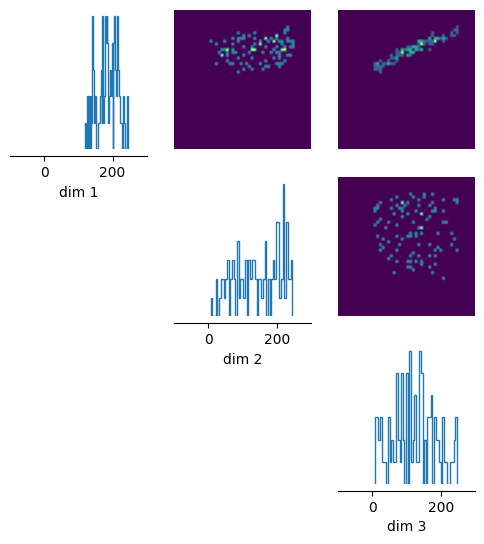

In [25]:
# Actual SNPE
num_rounds = 2
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=50, num_transforms=3)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 100
simulation_batch_size = 15

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

posterior_samples_RNN = posterior.sample((100,), x=true_data)
_ = analysis.pairplot(
    posterior_samples_RNN, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

Try whether Athos- simulator works

In [31]:
###### Simulate
headers = ["k1" , "k2", "k3"]          # parameters to be inferred
num_timesteps = 100

# FOR SNLE
prior_min = 0.01                        # same for all parameters
prior_max = 250    

t = np.linspace(0, 100, num_timesteps)

param_dict = {'k1': 246.96291990024542, 'k2': 246.96291990024542, 'k3': 246.96291990024542, 'n1': 5, 'n2': 5, 'n3': 5, 'dm1': 1.143402097500176, 'dm2': 1.143402097500176, 'dm3': 1.143402097500176, 'dp1': 0.7833664565550977, 'dp2': 0.7833664565550977, 'dp3': 0.7833664565550977,
              'a1': 24.78485282457379, 'a2': 24.78485282457379, 'a3': 24.78485282457379, 'g1': 0.024884149937163258, 'g2': 0.024884149937163258, 'g3': 0.024884149937163258, 'b1': 33.82307682700831, 'b2': 33.82307682700831, 'b3': 33.82307682700831}

all_params = 'a1', 'a2', 'a3', 'g1', 'g2', 'g3', 'dm1', 'dm2', 'dm3', 'dp1', 'dp2', 'dp3', 'b1', 'b2', 'b3', 'n1', 'n2', 'n3', 'k1', 'k2', 'k3'
new_param_dict ={}
for param in all_params:
    if param not in headers:
        new_param_dict[param] = param_dict[param]
    elif param in headers:
        new_param_dict[param] = param

def my_simulator(theta):
    def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

    def solve_ode(theta, t):
        initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
        y = odeint(model, initial_conditions, t, args=(theta,))
                 #raw output
        return torch.tensor(y, dtype=torch.float32)
    return solve_ode(theta, t)
prior = utils.BoxUniform(
    low=torch.tensor([10**-2,10**-2,10**-2]),
    high=torch.tensor([250.,250.,250.]))
true_params = tuple(param_dict[parameter] for parameter in headers)
true_data = my_simulator(true_params)
num_dim = len(true_params)
true_data.shape

torch.Size([100, 6])

In [32]:
simulator_wrapper, prior = prepare_for_sbi(my_simulator, prior)
batch_size = 3


In [33]:
fourdim = simulator_wrapper(prior.sample((batch_size,)))
fourdim.shape

torch.Size([3, 100, 6])

# Try actual SNPE from .py file

In [1]:
### IMPORT PACKAGES AND ALSO REWRITE FUNCTIONS ###

import torch
import multiprocessing
import os

def get_gpu_count():
    return torch.cuda.device_count()

def get_cpu_count():
    return multiprocessing.cpu_count()

if __name__ == "__main__":
    num_gpus = get_gpu_count()
    num_cpus = get_cpu_count()
    print("Number of GPUs (torch.cuda.device_count()):", num_gpus)
    print("Number of CPUs (multiprocessing.cpu_count()):", num_cpus)

print("Number of CPUs (os.cpu_count()):", os.cpu_count())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np

import joblib
import math
from math import ceil
import random
import contextlib
import torch
import sys
from numpy import fft, ndarray
from scipy.stats import norm
import os
import seaborn as sns
from pyro.infer.mcmc.api import MCMC
from warnings import warn
from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union, Dict
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm, trange
from pyro.infer.mcmc import HMC, NUTS
from sbi.inference import prepare_for_sbi, SNLE
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.types import Shape, TorchTransform
from sbi.utils.get_nn_models import (likelihood_nn,)
from sbi.samplers.mcmc import SliceSamplerVectorized
from sbi.samplers.mcmc.slice_numpy import MCMCSampler
from sbi.utils import tensor2numpy

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(10_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)
    
    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress
    
    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

class SliceSampler(MCMCSampler):
    def __init__(self, x, lp_f, max_width=float("inf"), init_width: Union[float, np.ndarray] = 0.05, thin=None, tuning: int = 50, verbose: bool = False,):
        MCMCSampler.__init__(self, x, lp_f, thin, verbose=verbose)
        self.max_width = max_width
        self.init_width = init_width
        self.width = None
        self.tuning = tuning
        
    def _tune_bracket_width(self, rng):
        order = list(range(self.n_dims))
        x = self.x.copy()

        self.width = np.full(self.n_dims, self.init_width)

        tbar = trange(self.tuning, miniters=2, disable=not self.verbose)
        tbar.set_description("Tuning bracket width...")
        for n in tbar:
            # for n in range(int(self.tuning)):
            rng.shuffle(order)
            for i in range(self.n_dims):
                x[i], wi = self._sample_from_conditional(i, x[i], rng)
                self.width[i] += (wi - self.width[i]) / (n + 1)

    def _sample_from_conditional(self, i: int, cxi, rng):
        assert self.width is not None, "Chain not initialized."

        # conditional log prob
        Li = lambda t: self.lp_f(np.concatenate([self.x[:i], [t], self.x[i + 1 :]]))
        wi = self.width[i]

        # sample a slice uniformly
        logu = Li(cxi) + np.log(1.0 - rng.rand())

        # position the bracket randomly around the current sample
        lx = cxi - wi * rng.rand()
        ux = lx + wi
        
        # find lower bracket end
        while Li(lx) >= logu and cxi - lx < self.max_width:
            lx -= wi

        # find upper bracket end
        while Li(ux) >= logu and ux - cxi < self.max_width:
            ux += wi

        # sample uniformly from bracket
        xi = (ux - lx) * rng.rand() + lx

        # if outside slice, reject sample and shrink bracket
        while Li(xi) < logu:
            if xi < cxi:
                lx = xi
            else:
                ux = xi
            xi = (ux - lx) * rng.rand() + lx
       
        return xi, ux - lx
      
def run_fun(SliceSamplerSerial, num_samples, inits, seed, log_prob_fn: Callable, thin: Optional[int] = None, tuning: int = 50, verbose: bool = True, init_width: Union[float, np.ndarray] = 0.01,
            max_width: float = float("inf"), num_workers: int = 1, rng=np.random, show_info: bool = False, logger=sys.stdout) -> np.ndarray:
    np.random.seed(seed)
    posterior_sampler = SliceSampler(inits, lp_f=log_prob_fn, max_width=max_width, init_width=init_width, thin=thin, tuning=tuning, verbose=num_workers == 1 and verbose,)
    
    assert num_samples >= 0, "number of samples can't be negative"

    order = list(range(posterior_sampler.n_dims))
    L_trace = []
    samples = np.empty([int(num_samples), int(posterior_sampler.n_dims)])
    logger = open(os.devnull, "w") if logger is None else logger

    if posterior_sampler.width is None:
        # logger.write('tuning bracket width...\n')
        posterior_sampler._tune_bracket_width(rng)

    tbar = trange(int(num_samples), miniters=10, disable=not posterior_sampler.verbose)
    tbar.set_description("Generating samples")
    for n in tbar:
        # for n in range(int(n_samples)):
        for _ in range(posterior_sampler.thin):
            rng.shuffle(order)

            for i in order:
                posterior_sampler.x[i], _ = posterior_sampler._sample_from_conditional(i, posterior_sampler.x[i], rng)

        samples[n] = posterior_sampler.x.copy()

        posterior_sampler.L = posterior_sampler.lp_f(posterior_sampler.x)
        # logger.write('sample = {0}, log prob = {1:.2}\n'.format(n+1, self.L))

        if show_info:
            L_trace.append(posterior_sampler.L)

    # show trace plot
    if show_info:
        fig, ax = plt.subplots(1, 1)
        ax.plot(L_trace)
        ax.set_ylabel("log probability")
        ax.set_xlabel("samples")
        plt.show(block=False)

    return samples

def run(SliceSamplerSerial, log_prob_fn: Callable, num_samples: int, init_params: np.ndarray, num_chains: int = 1, thin: Optional[int] = None, verbose: bool = True, num_workers: int = 1,) -> np.ndarray:
    num_chains , dim_samples = init_params.shape
    # Generate seeds for workers from current random state.
    seeds = torch.randint(high=1_000_000, size=(num_chains,))
    for seed in seeds:
        seed_all_backends(seed)
    with tqdm_joblib(tqdm(range(num_chains), disable=not verbose, desc=f"""Running {num_chains} MCMC chains with {num_workers} worker{"s" if num_workers>1 else ""}.""", total=num_chains,)):
        all_samples = Parallel(n_jobs=num_workers)(delayed(run_fun)(SliceSamplerSerial, num_samples, initial_params_batch, seed, log_prob_fn)for initial_params_batch, seed in zip(init_params, seeds))
    samples = np.stack(all_samples).astype(np.float32)
    samples = samples.reshape(num_chains, -1, dim_samples)  # chains, samples, dim
    samples = samples[:, :: thin, :]  # thin chains

    # save samples
    return samples

class SliceSamplerSerial:
    def __init__(self, log_prob_fn: Callable, init_params: np.ndarray, num_chains: int = 1, thin: Optional[int] = None, tuning: int = 50, verbose: bool = True, init_width: Union[float, np.ndarray] = 0.01, max_width: float = float("inf"), num_workers: int = 1,):
        self._log_prob_fn = log_prob_fn
        self.x = init_params
        self.num_chains = num_chains
        self.thin = thin
        self.tuning = tuning
        self.verbose = verbose
        self.init_width = init_width
        self.max_width = max_width
        self.n_dims = self.x.size
        self.num_workers = num_workers
        self._samples = None

    def get_samples(self, num_samples: Optional[int] = None, group_by_chain: bool = True) -> np.ndarray:
        if self._samples is None:
            raise ValueError("No samples found from MCMC run.")
        # if not grouped by chain, flatten samples into (all_samples, dim_params)
        if not group_by_chain:
            samples = self._samples.reshape(-1, self._samples.shape[2])
        else:
            samples = self._samples

        # if not specified return all samples
        if num_samples is None:
            return samples
        # otherwise return last num_samples (for each chain when grouped).
        elif group_by_chain:
            return samples[:, -num_samples:, :]
        else:
            return samples[-num_samples:, :]

##############################################################################################################################
        
def _maybe_use_dict_entry(default: Any, key: str, dict_to_check: Dict) -> Any:
    attribute = default if key not in dict_to_check.keys() else dict_to_check[key]
    return attribute

def _get_initial_params(proposal, init_strategy: str, num_chains: int, num_workers: int, show_progress_bars: bool, **kwargs,) -> Tensor: 
    # Build init function
    init_fn = proposal._build_mcmc_init_fn(proposal.proposal, proposal.potential_fn, transform=proposal.theta_transform, init_strategy=init_strategy, **kwargs,)

    # Parallelize inits for resampling only.
    if num_workers > 1 and (init_strategy == "resample" or init_strategy == "sir"):
        def seeded_init_fn(seed):
            torch.manual_seed(seed)
            return init_fn()

        seeds = torch.randint(high=10_000_000, size=(num_chains,))

        # Generate initial params parallelized over num_workers.
        with tqdm_joblib(tqdm(range(num_chains), disable=not show_progress_bars, desc=f"""Generating {num_chains} MCMC inits with {num_workers} workers.""", total=num_chains,)):
            initial_params = torch.cat(Parallel(n_jobs=num_workers)(delayed(seeded_init_fn)(seed) for seed in seeds))
    else:
        initial_params = torch.cat([init_fn() for _ in range(num_chains)])
    return initial_params
    
def _slice_np_mcmc(proposal, num_samples: int, potential_function: Callable, initial_params: Tensor, thin: int, warmup_steps: int, vectorized: bool = False, num_workers: int = 1, init_width: Union[float, ndarray] = 0.01, show_progress_bars: bool = True,) -> Tensor:
    num_chains, dim_samples = initial_params.shape
        
    if not vectorized:
        SliceSamplerMultiChain = SliceSamplerSerial
    else:
        SliceSamplerMultiChain = SliceSamplerVectorized

    posterior_sampler = SliceSamplerMultiChain(init_params=tensor2numpy(initial_params), log_prob_fn=potential_function, num_chains=num_chains, thin=thin, verbose=show_progress_bars, num_workers=num_workers, init_width=init_width,)
    warmup_ = warmup_steps * thin
    num_samples_ = ceil((num_samples * thin) / num_chains)
    # Run mcmc including warmup
    samples = run(posterior_sampler, log_prob_fn=potential_function, num_samples = (warmup_ + num_samples_), init_params = tensor2numpy(initial_params))
    samples = samples[:, warmup_steps:, :]  # discard warmup steps
    samples = torch.from_numpy(samples)  # chains x samples x dim

    # Save posterior sampler.
    proposal._posterior_sampler = posterior_sampler

    # Save sample as potential next init (if init_strategy == 'latest_sample').
    proposal._mcmc_init_params = samples[:, -1, :].reshape(num_chains, dim_samples)

    # Collect samples from all chains.
    samples = samples.reshape(-1, dim_samples)[:num_samples, :]
    assert samples.shape[0] == num_samples
    return samples.type(torch.float32).to(proposal._device)

def sample_my_fun(proposal, sample_shape: Shape = torch.Size(), x: Optional[Tensor] = None, method: Optional[str] = None, thin: Optional[int] = None, warmup_steps: Optional[int] = None, num_chains: Optional[int] = None, init_strategy: Optional[str] = None, init_strategy_parameters: Optional[Dict[str, Any]] = None,
                   init_strategy_num_candidates: Optional[int] = None, mcmc_parameters: Dict = {}, mcmc_method: Optional[str] = None, sample_with: Optional[str] = None, num_workers: Optional[int] = None, show_progress_bars: bool = True,) -> Tensor:
    
    proposal.potential_fn.set_x(proposal._x_else_default_x(x))

    # Replace arguments that were not passed with their default.
    method = proposal.method if method is None else method
    thin = proposal.thin if thin is None else thin
    warmup_steps = proposal.warmup_steps if warmup_steps is None else warmup_steps
    num_chains = proposal.num_chains if num_chains is None else num_chains
    init_strategy = proposal.init_strategy if init_strategy is None else init_strategy
    num_workers = proposal.num_workers if num_workers is None else num_workers
    init_strategy_parameters = (proposal.init_strategy_parameters if init_strategy_parameters is None else init_strategy_parameters)

    if init_strategy_num_candidates is not None:
        warn("""Passing `init_strategy_num_candidates` is deprecated as of sbi v0.19.0. Instead, use e.g.,`init_strategy_parameters={"num_candidate_samples": 1000}`""")
        proposal.init_strategy_parameters["num_candidate_samples"] = (init_strategy_num_candidates)
    if sample_with is not None:
        raise ValueError(f"You set `sample_with={sample_with}`. As of sbi v0.18.0, setting `sample_with` is no longer supported. You have to rerun `.build_posterior(sample_with={sample_with}).`")
    if mcmc_method is not None:
        warn("You passed `mcmc_method` to `.sample()`. As of sbi v0.18.0, this is deprecated and will be removed in a future release. Use `method` instead of `mcmc_method`.")
        method = mcmc_method
    if mcmc_parameters:
        warn("You passed `mcmc_parameters` to `.sample()`. As of sbi v0.18.0, this is deprecated and will be removed in a future release. Instead, pass the variable to `.sample()` directly, e.g. `posterior.sample((1,), num_chains=5)`.")
    # The following lines are only for backwards compatibility with sbi v0.17.2 or older.
    m_p = mcmc_parameters  # define to shorten the variable name
    method = _maybe_use_dict_entry(method, "mcmc_method", m_p)
    thin = _maybe_use_dict_entry(thin, "thin", m_p)
    warmup_steps = _maybe_use_dict_entry(warmup_steps, "warmup_steps", m_p)
    num_chains = _maybe_use_dict_entry(num_chains, "num_chains", m_p)
    init_strategy = _maybe_use_dict_entry(init_strategy, "init_strategy", m_p)
    proposal.potential_ = proposal._prepare_potential(method)  # type: ignore

    initial_params = _get_initial_params(proposal, init_strategy, num_chains, num_workers, show_progress_bars, **init_strategy_parameters,)
    num_samples = torch.Size(sample_shape).numel()

    track_gradients = method in ("hmc", "nuts")
    with torch.set_grad_enabled(track_gradients):
        if method in ("slice_np", "slice_np_vectorized"):
            transformed_samples = _slice_np_mcmc(proposal, num_samples=num_samples, potential_function=proposal.potential_, initial_params=initial_params, thin=thin, warmup_steps=warmup_steps, vectorized=(method == "slice_np_vectorized"), num_workers=num_workers, show_progress_bars=show_progress_bars,)
        elif method in ("hmc", "nuts", "slice"):
            transformed_samples = _pyro_mcmc(proposal, num_samples=num_samples, potential_function=proposal.potential_, initial_params=initial_params, mcmc_method=method, thin=thin, warmup_steps=warmup_steps, num_chains=num_chains, show_progress_bars=show_progress_bars,)
        else:
            raise NameError

    samples = proposal.theta_transform.inv(transformed_samples)

    return samples.reshape((*sample_shape, -1))  # type: ignore

#######################################################################################################################################

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1 , seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:
    num_sims, *_ = theta.shape
    seed_all_backends(seed)
    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)
        
        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))
            with tqdm_joblib(tqdm(batches, disable=not show_progress_bars, total = len(batches), desc=f"Running {num_sims} simulations in {len(batches)} batches ({num_workers} cores)",)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed) for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )
            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)
        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)
    return x

def simulate_for_sbi(round_idx: int, simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1, simulation_batch_size: int = 1, seed: Optional[int] = None, show_progress_bar: bool = True)-> Tuple[Tensor, Tensor]:
    if round_idx == 0:
        theta = proposal.sample((num_simulations,))
    else:
        theta = sample_my_fun(proposal, (num_simulations,), num_workers = num_workers, num_chains = 4) # because only in first round proposal is boxuniform, then it is mcmcposterior object
    
    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size, num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar)
    
    return theta, x

### Parallelisation ###
##### paralellise #####

#Parallelise it
# PART 1: Edited code from original sbi repos. Functions edited: simulate_for_sbi, and all the functions it contains.
#Main changes: defined simulator_seeded globally rather than within simulate_in_batches function, and re-imported torch within simulator_seeded 
#NO changes need to be made in this file

# PART 2: Essentially the unparallelised code with 2 extra arguments in the simulate_for_sbi line

##################################### PART 1 #########################################
import joblib
import contextlib
import random
import torch
import numpy as np

from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sbi
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

from sbi.inference import SNLE, prepare_for_sbi
# No longer importing simulate_for_sbi from the package, we use the one defined above
from sbi import utils as utils
from sbi import analysis as analysis

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(1_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1,
                        seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:

    num_sims, *_ = theta.shape
    seed_all_backends(seed)

    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)

        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))

            with tqdm_joblib(
                tqdm(batches, disable=not show_progress_bars,
                     desc=f"Running {num_sims} simulations in {len(batches)} batches.", total=len(batches),)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed)
                    for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )

            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)

        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)

    return x


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

def simulate_for_sbi(simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1,
                     simulation_batch_size: int = 1, seed: Optional[int] = None,
                     show_progress_bar: bool = True, ) -> Tuple[Tensor, Tensor]:

    theta = proposal.sample((num_simulations,))

    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size,
                            num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar,)

    return theta, x

######################################################################################################

# To parallelise, set number of CPUs to be used. Note: parallelise anything that has num_rounds>2 and/or num_simulations>50
# to see total available CPUs: print(os.cpu_count())

CPUs_to_use = 8

total_CPUs = os.cpu_count()
num_workers = CPUs_to_use - total_CPUs -1
# num_workers = -1 uses all cpus
# num_workers = -2 uses all cpus but one etc https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
if CPUs_to_use > total_CPUs:
    raise ValueError(f"Cannot use more CPUs than are available. Available CPUs: {total_CPUs}")

######################################################################################################


Number of GPUs (torch.cuda.device_count()): 0
Number of CPUs (multiprocessing.cpu_count()): 8
Number of CPUs (os.cpu_count()): 8


In [2]:
#Simulator
###### Simulate
headers = ["k1" , "k2", "k3"]          # parameters to be inferred
num_timesteps = 100

# FOR SNLE
prior_min = 0.01                        # same for all parameters
prior_max = 250    

t = np.linspace(0, 100, num_timesteps)

param_dict = {'k1': 246.96291990024542, 'k2': 246.96291990024542, 'k3': 246.96291990024542, 'n1': 5, 'n2': 5, 'n3': 5, 'dm1': 1.143402097500176, 'dm2': 1.143402097500176, 'dm3': 1.143402097500176, 'dp1': 0.7833664565550977, 'dp2': 0.7833664565550977, 'dp3': 0.7833664565550977,
              'a1': 24.78485282457379, 'a2': 24.78485282457379, 'a3': 24.78485282457379, 'g1': 0.024884149937163258, 'g2': 0.024884149937163258, 'g3': 0.024884149937163258, 'b1': 33.82307682700831, 'b2': 33.82307682700831, 'b3': 33.82307682700831}

all_params = 'a1', 'a2', 'a3', 'g1', 'g2', 'g3', 'dm1', 'dm2', 'dm3', 'dp1', 'dp2', 'dp3', 'b1', 'b2', 'b3', 'n1', 'n2', 'n3', 'k1', 'k2', 'k3'
new_param_dict ={}
for param in all_params:
    if param not in headers:
        new_param_dict[param] = param_dict[param]
    elif param in headers:
        new_param_dict[param] = param

def my_simulator(theta):
    def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

    def solve_ode(theta, t):
        initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
        y = odeint(model, initial_conditions, t, args=(theta,))
                 #raw output
        return torch.tensor(y, dtype=torch.float32)
    return solve_ode(theta, t)
prior = utils.BoxUniform(
    low=torch.tensor([10**-2,10**-2,10**-2]),
    high=torch.tensor([250.,250.,250.]))
true_params = tuple(param_dict[parameter] for parameter in headers)
true_data = my_simulator(true_params)
num_dim = len(true_params)

#Embedding net RNN
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True) #batch_size of 100
        self.linear = nn.Linear(hidden_size, output_size)

                                                       #The middle value needs to be the length, in this case 1000, or input.size(0) (try with true_data)
                                                        #1 is the number of layers
                                                        #Actually prepare for sbi adds a batch_size, so x.shape is (1, 1000, 6)
    def forward(self, x):
        h = torch.zeros(1, x.size(0), self.hidden_size)
        gru_out, hn = self.gru(
            x, h)
        output = self.linear(gru_out[:,-1, :])
        return output

# Example usage
input_size = 6 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


# Actual SNPE
num_rounds = 2
simulator_wrapper, prior = prepare_for_sbi(my_simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=50, num_transforms=3)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 100
simulation_batch_size = 15

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator, sample_with="mcmc")
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

posterior_samples_RNN = posterior.sample((100,), x=true_data)

Running 100 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

 Neural network successfully converged after 63 epochs.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

Running 100 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 94 epochs.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

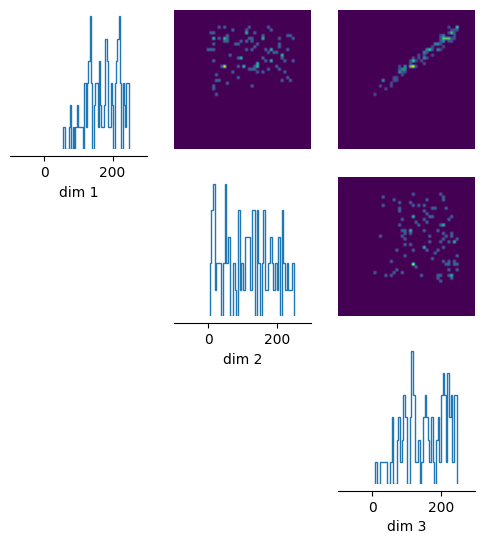

In [4]:
posterior_samples_RNN = posterior.sample((100,), x=true_data)
_ = analysis.pairplot(
    posterior_samples_RNN, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

# Now bigger simulation 5 rounds

In [ ]:
# Actual SNPE
embedding_net_custom = SummaryNet()
num_rounds = 5
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net_custom, hidden_features=50, num_transforms=3)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 3000
simulation_batch_size = 400

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

posterior_samples_RNN = posterior.sample((50000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples_RNN, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

# Now same but for 6 parameters

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np

# Old simulator without loops...
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1,k2,k3,a1,a2,a3=params #only 3 ks are parameters to infer
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dm1dt = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dp1dt = (b1 * m1) - (dp1 * p1)
    dm2dt = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dp2dt = (b2 * m2) - (dp2 * p2)
    dm3dt = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dp3dt = (b3 * m3)-(dp3 * p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

# Initial conditions
true_params = torch.tensor([
    246.96291990024542, 246.96291990024542, 246.96291990024542,
    24.78485282457379, 24.78485282457379, 24.78485282457379]).unsqueeze(0)
num_timesteps = 100
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    full_tensor = torch.zeros((num_trajectories * num_timesteps)).unsqueeze(0)
    if len(parameter_set) == 1:
        for params in parameter_set:
            y = odeint(model, y0, t, args=(params,))
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            final_tensor = yt.unsqueeze(0).unsqueeze(-1)
            return final_tensor
    else:
        for params in parameter_set:
            y = odeint(model, y0, t, args=(params,))
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            true_tensor = yt.unsqueeze(0)
            full_tensor = torch.cat((full_tensor, true_tensor), dim=0)
        n_sims = full_tensor.size(0)
        output_tensor = full_tensor[1:n_sims]
        out = output_tensor.unsqueeze(-1)
        return out
    
prior = utils.BoxUniform(
    low=torch.tensor([10**-2,10**-2,10**-2,20.,20.,20.]),
    high=torch.tensor([250.,250.,250.,40.,40.,40.]), device=device)

true_data = simulator(true_params)

In [ ]:
# Actual SNPE
num_rounds = 2
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net_custom, hidden_features=50, num_transforms=3)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 3000
simulation_batch_size = 400

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

posterior_samples_RNN = posterior.sample((50000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples_RNN, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

# Now bigger simulation 5 rounds

In [ ]:
# Actual SNPE
embedding_net_custom = SummaryNet()
num_rounds = 5
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net_custom, hidden_features=50, num_transforms=3)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 3000
simulation_batch_size = 400

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

posterior_samples_RNN = posterior.sample((50000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples_RNN, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)